# 0. Load Libraries

## 0.1: install libraries

In [1]:
! pip install imblearn
! pip install xgboost

## 0.2: Import Libraries

In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import re

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Model evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Data balancing
from imblearn.over_sampling import SMOTE

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l1_l2

# Model serialization
import pickle

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Ensure all needed class weights and additional sklearn tools
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Text Preprocessing

## 1.0: data info

In [3]:
df = pd.read_csv('../data/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

## 1.1 Lemmatization and stop word removal

In [5]:
# lemmatize all words
def lemmatize_text(review):
    lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(review)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in token_words]
    return " ".join(lemmatized_words)

# remove stopwords
def remove_stopwords(review):
    tokens = word_tokenize(review)
    stop_words = stopwords.words('english')
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# arrange text
def clean_text(review):
    text = re.sub(r'[^a-zA-Z\s]', '', review) # Keeps only letters and spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [6]:
X = df['posts'].apply(lemmatize_text).apply(remove_stopwords).apply(clean_text)

## 1.2: Encode labels for MBTI Categories 

In [7]:
# Encoding categorical labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])

# Store label encoding mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [8]:
# Data save
data_to_save = pd.DataFrame({'Processed_Posts': X, 'Labels': y})
data_to_save.to_csv('../data/processed_data.csv', index=False)

## 1.3: Manipulate Train-Test Split

In [9]:
data = pd.read_csv('../data/processed_data.csv')

# Extract features and target
X = data['Processed_Posts']
y = data['Labels']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
pd.Series(y_train).value_counts()

Labels
9     1462
8     1182
11    1011
10     898
1      550
3      550
15     270
13     218
2      187
14     161
0      149
12     121
7       74
5       40
4       35
6       32
Name: count, dtype: int64

## 1.3: Normalization by TF-IDF & SMOTE

In [11]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data to numerical format using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_tfidf = tfidf_vectorizer.transform(X_test)      

# Address class imbalance in the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [12]:
pd.Series(y_train_smote).value_counts()

Labels
8     1462
1     1462
3     1462
9     1462
0     1462
10    1462
2     1462
11    1462
4     1462
13    1462
15    1462
12    1462
6     1462
7     1462
14    1462
5     1462
Name: count, dtype: int64

# 2: Model training

In [13]:
# Dictionary to hold models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

Logistic Regression - Accuracy: 0.6870317002881844
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.62      0.37      0.46        41
           1       0.69      0.66      0.67       125
           2       0.57      0.48      0.52        44
           3       0.65      0.62      0.63       135
           4       0.25      0.29      0.27         7
           5       0.00      0.00      0.00         8
           6       0.50      0.43      0.46         7
           7       0.78      0.47      0.58        15
           8       0.71      0.68      0.69       288
           9       0.69      0.80      0.74       370
          10       0.64      0.70      0.67       193
          11       0.72      0.78      0.75       293
          12       0.90      0.62      0.74        45
          13       0.64      0.53      0.58        53
          14       0.79      0.52      0.63        44
          15       0.71      0.63    

/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest - Accuracy: 0.47723342939481267
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.05      0.09        41
           1       0.64      0.29      0.40       125
           2       0.56      0.11      0.19        44
           3       0.60      0.29      0.39       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.41      0.59      0.49       288
           9       0.42      0.81      0.55       370
          10       0.54      0.41      0.46       193
          11       0.59      0.61      0.60       293
          12       1.00      0.04      0.09        45
          13       0.83      0.09      0.17        53
          14       0.50      0.05      0.08        44
          15       0.75      0.18      0.29     

/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost - Accuracy: 0.6501440922190201
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.67      0.20      0.30        41
           1       0.66      0.60      0.63       125
           2       0.53      0.41      0.46        44
           3       0.59      0.61      0.60       135
           4       0.50      0.14      0.22         7
           5       1.00      0.12      0.22         8
           6       0.50      0.14      0.22         7
           7       0.75      0.40      0.52        15
           8       0.63      0.66      0.65       288
           9       0.65      0.83      0.73       370
          10       0.62      0.66      0.64       193
          11       0.72      0.70      0.71       293
          12       0.84      0.47      0.60        45
          13       0.67      0.49      0.57        53
          14       0.63      0.50      0.56        44
          15       0.63      0.55      0.59        67

    ac

/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3. Tuning Parameter

## 3.1: Use RandomsearchCV for hyper-parameter tuning
- 80% for model training.
- 20% for model testing.

In [13]:
# Define parameter
param_dist = [
    {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': ['l2'], 'C': loguniform(1e-4, 1e+2)},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': loguniform(1e-4, 1e+2)},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': loguniform(1e-4, 1e+2), 'l1_ratio': np.linspace(0.1, 0.9, 10)},
    {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': [None]} 
]

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Setup RandomizedSearchCV with verbose output
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='accuracy', n_jobs=-1, cv=3, random_state=42, verbose=3)

# Fit the RandomizedSearchCV to find the best parameters
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters found
print("Best Parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions on the test set
y_pred_test = random_search.best_estimator_.predict(X_test_tfidf)

# Calculate and print accuracy, precision, and recall for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END C=0.3811544088653064, penalty=l2, solver=lbfgs;, score=0.910 total time=  46.9s
[CV 1/3] END C=0.0018794668241638478, penalty=l2, solver=liblinear;, score=0.740 total time=   6.4s
[CV 3/3] END C=0.0018794668241638478, penalty=l2, solver=liblinear;, score=0.735 total time=   5.7s
[CV 2/3] END ....penalty=None, solver=newton-cg;, score=0.938 total time= 2.3min
[CV 1/3] END C=0.006690421166498805, penalty=l2, solver=lbfgs;, score=0.743 total time=   8.8s
[CV 2/3] END C=0.006690421166498805, penalty=l2, solver=lbfgs;, score=0.817 total time=   7.6s
[CV 3/3] END C=0.006690421166498805, penalty=l2, solver=lbfgs;, score=0.774 total time=   6.9s
[CV 1/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.776 total time=  15.4s
[CV 2/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.851 total time=  13.7s
[CV 3/3] END C=0.039054412752107935, penalty=l2, solver=newton-cg;, score=0.824 to

/Users/jacksonzhao/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.2: Use best tunned parameter to test whole labels
- full dataset for y-labels
- save the best parameter for models

In [19]:
# use TF-IDF and Smote for retraining process
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X) 
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Best parameters as found from tuning
best_params = {'penalty': None, 'solver': 'saga'} 

# Initialize and train the Logistic Regression model using the best parameters on the entire dataset
model = LogisticRegression(**best_params, max_iter=1000)
model.fit(X_smote, y_smote)

LogisticRegression(max_iter=1000, penalty=None, solver='saga')

## 3.3: Save to the output path

In [20]:
# Save this best model to a pickle file
with open('../output/best_model_logistic_regression.pkl', 'wb') as file:
    pickle.dump(model, file)

print("The best model was saved to '../output/best_model_logistic_regression.pkl'")

The best model was saved to '../output/best_model_logistic_regression.pkl'


# 4. Extract Feature Importance

## 4.1: feature balancing

In [24]:
# Balancing data by SMOTE
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

In [25]:
# Extract the models with best parameter
filename = '../output/best_model_logistic_regression.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

## 4.2: label manipulation

In [26]:
# set up mapping between label indices and label names
coef = model.coef_

# mapping labels to names
map_label = {}
for key, val in label_mapping.items():
  map_label[val] = key

## 4.3 Visualization of feature importance

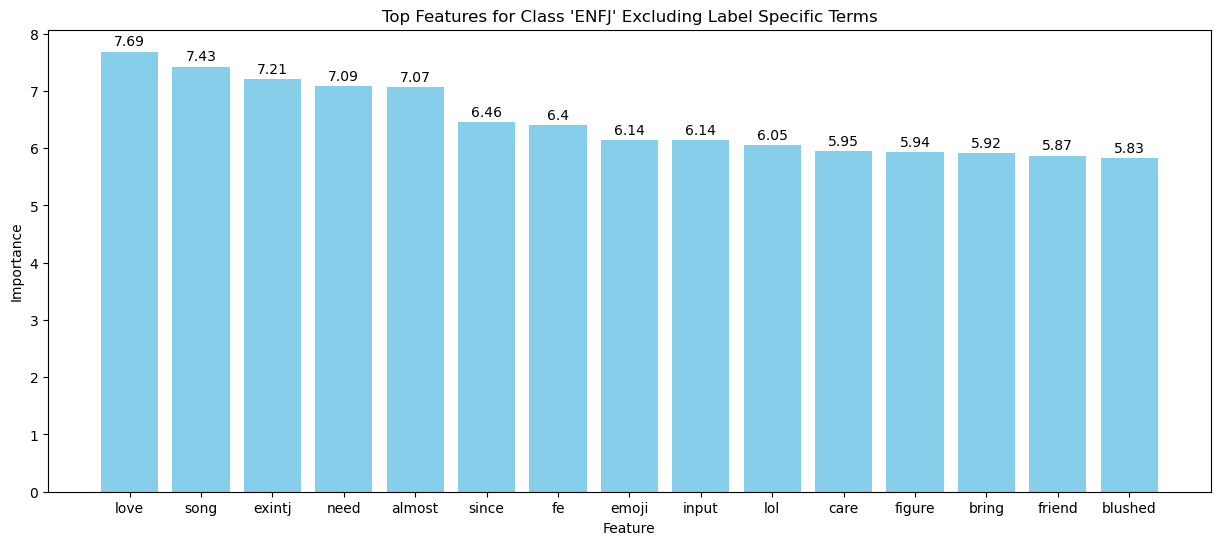

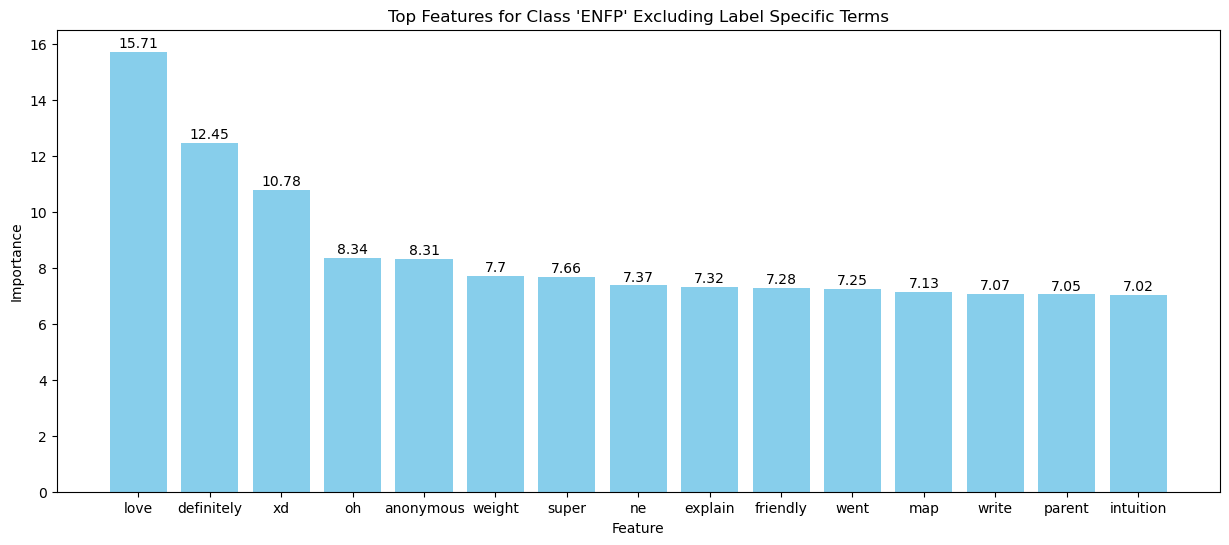

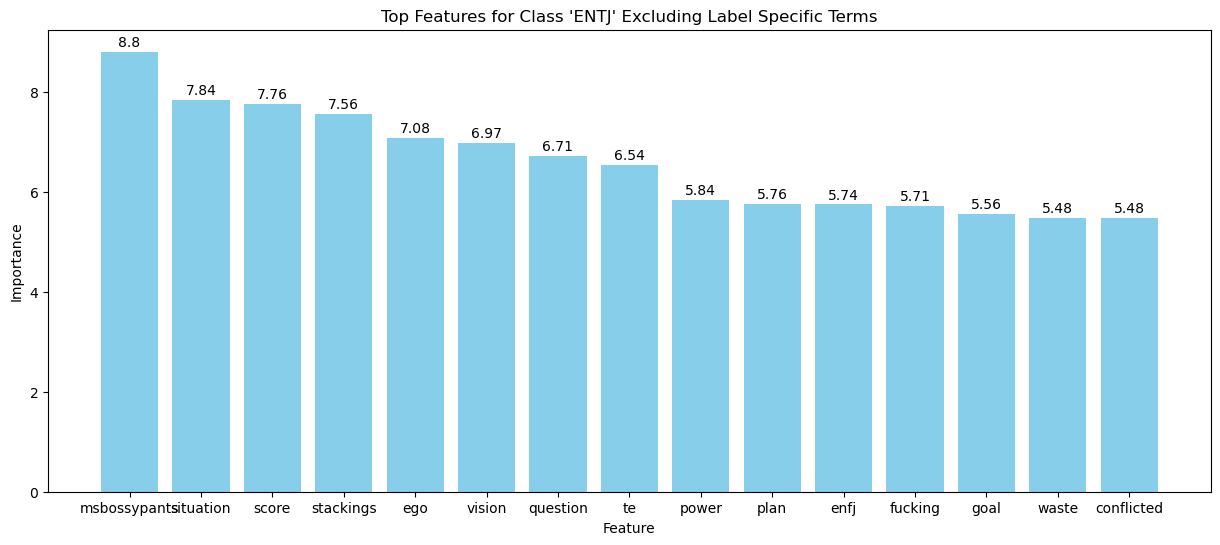

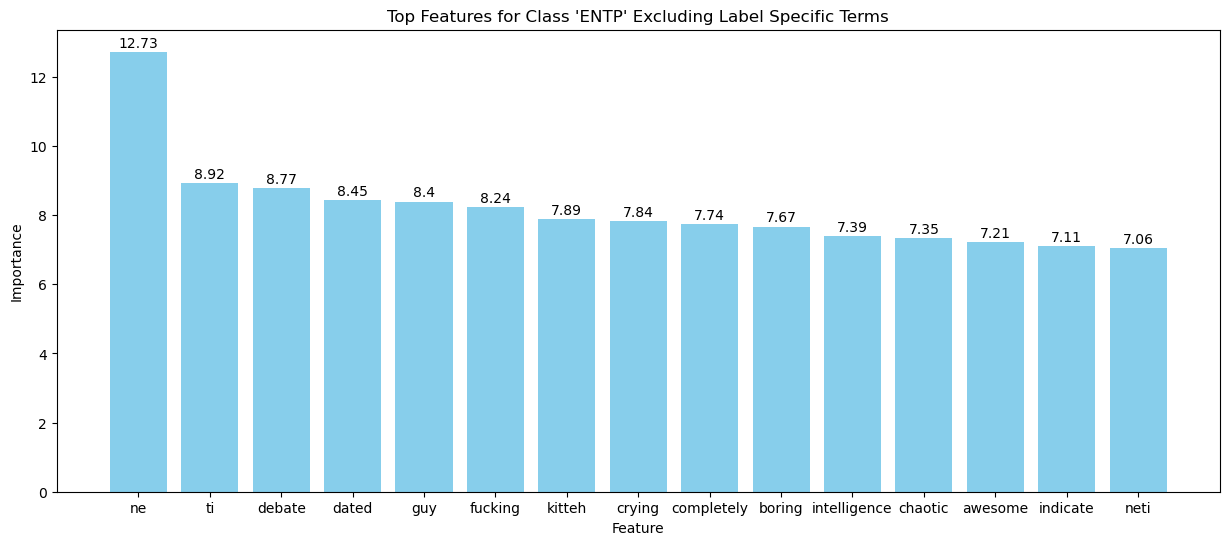

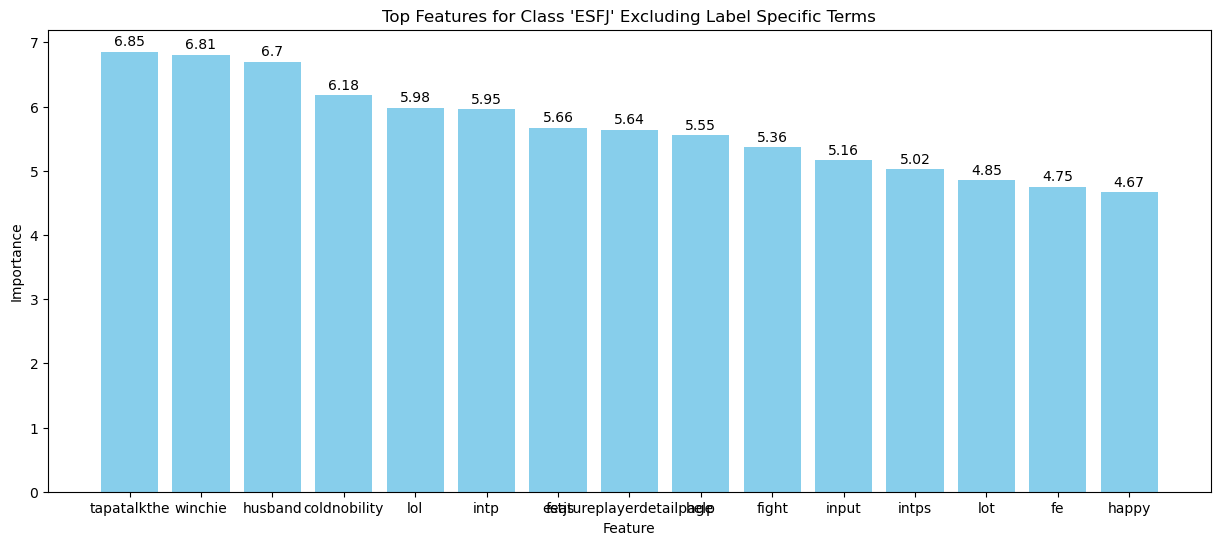

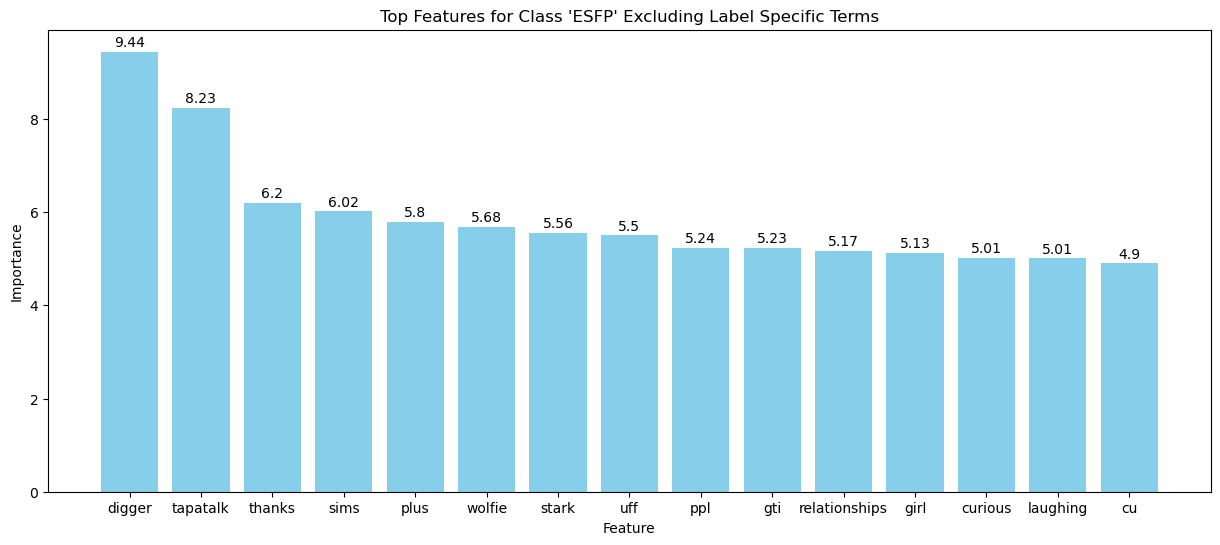

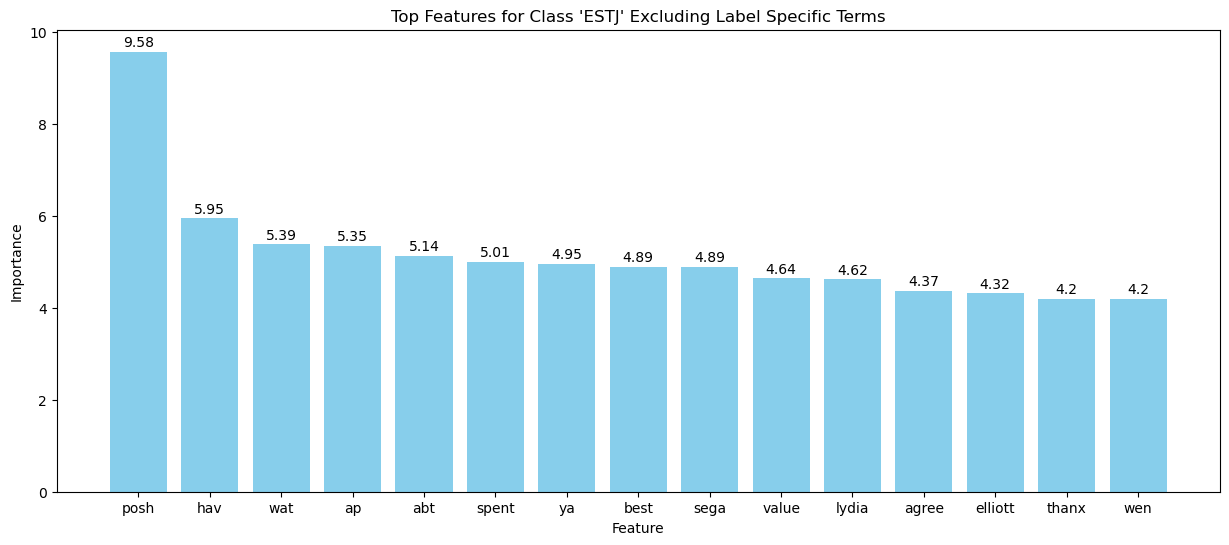

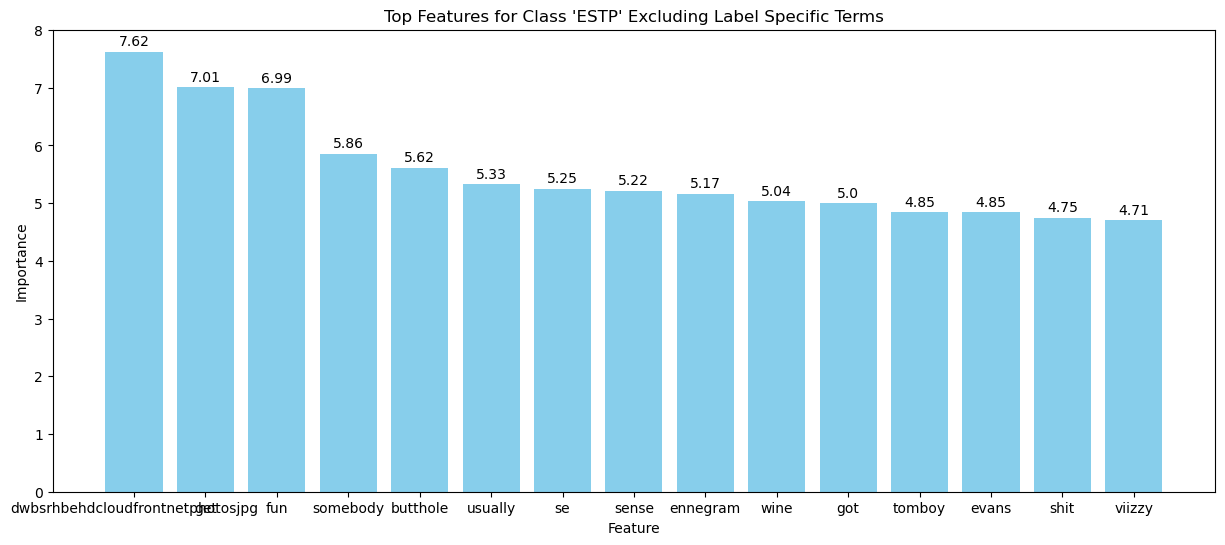

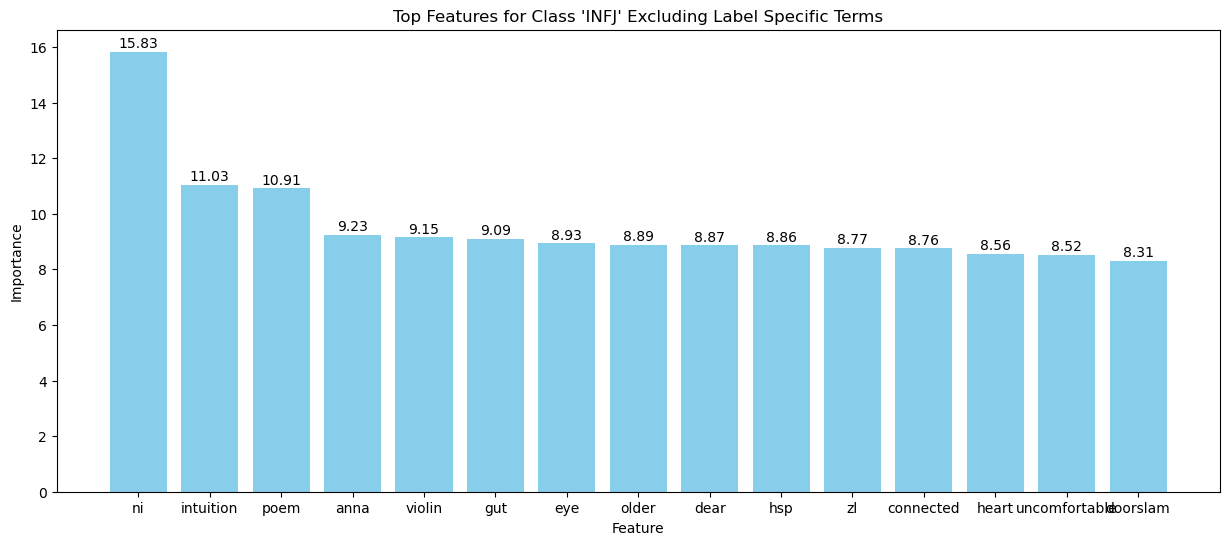

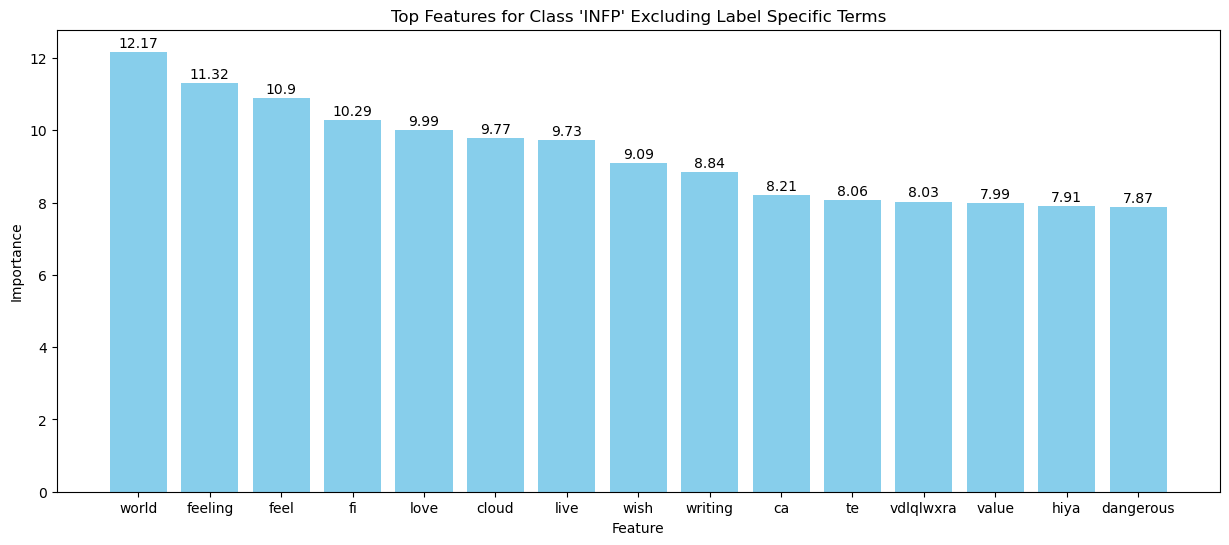

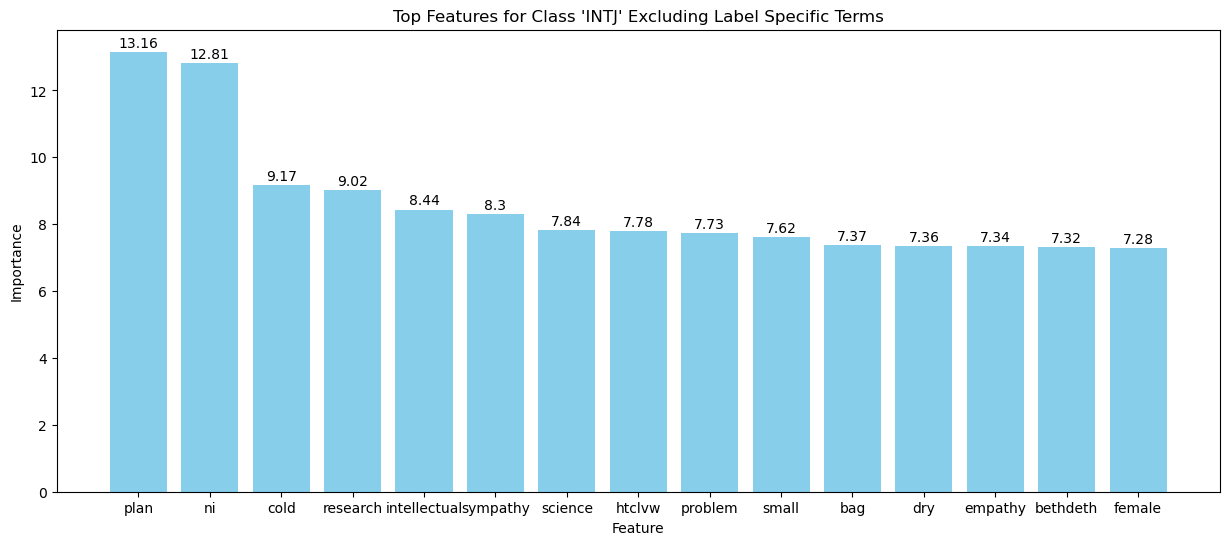

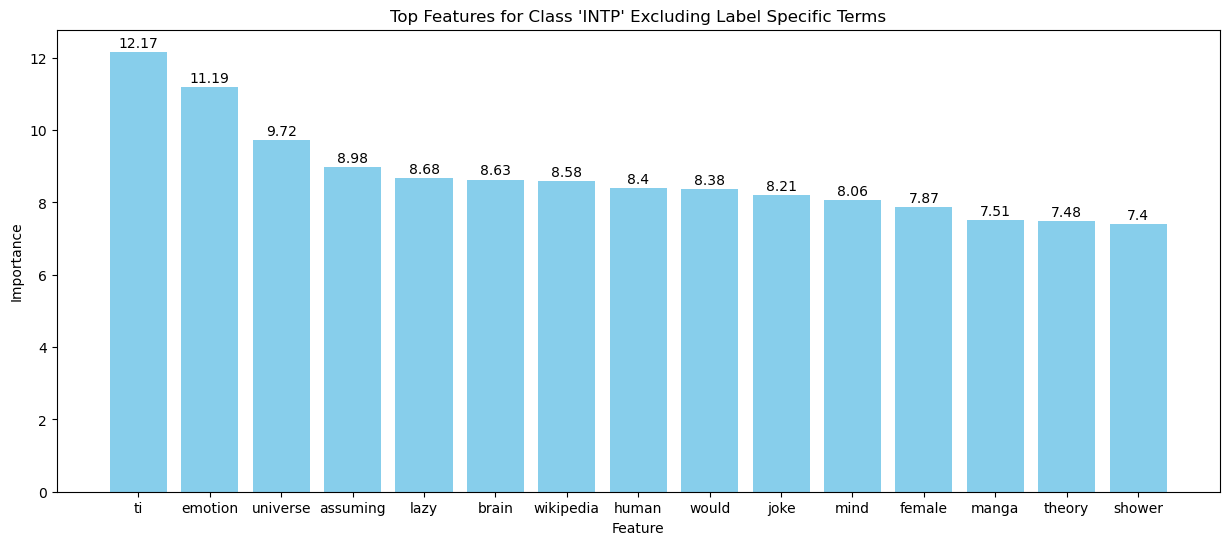

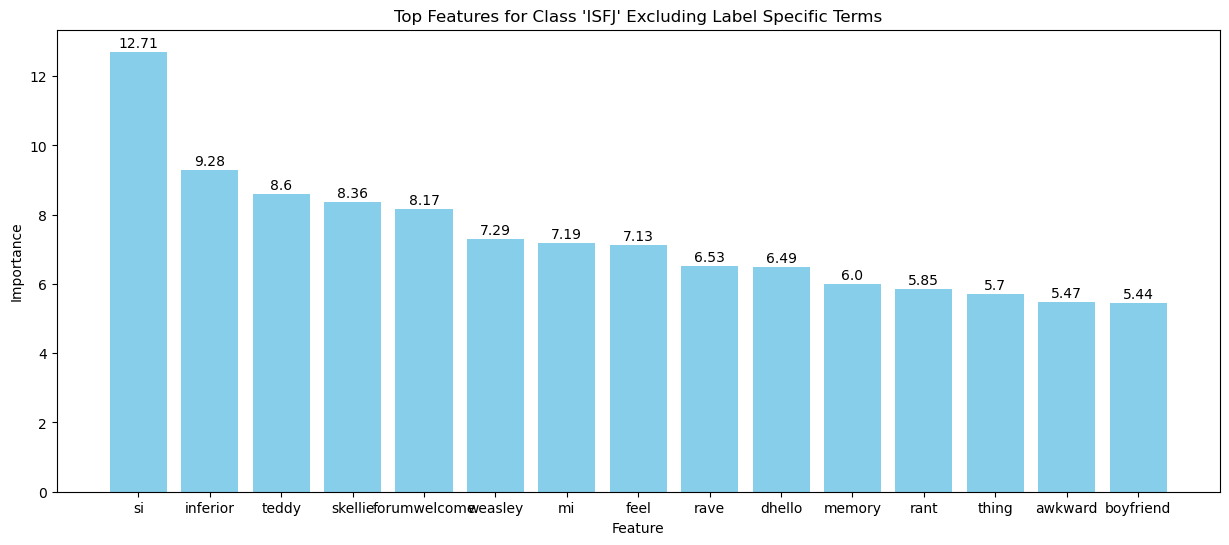

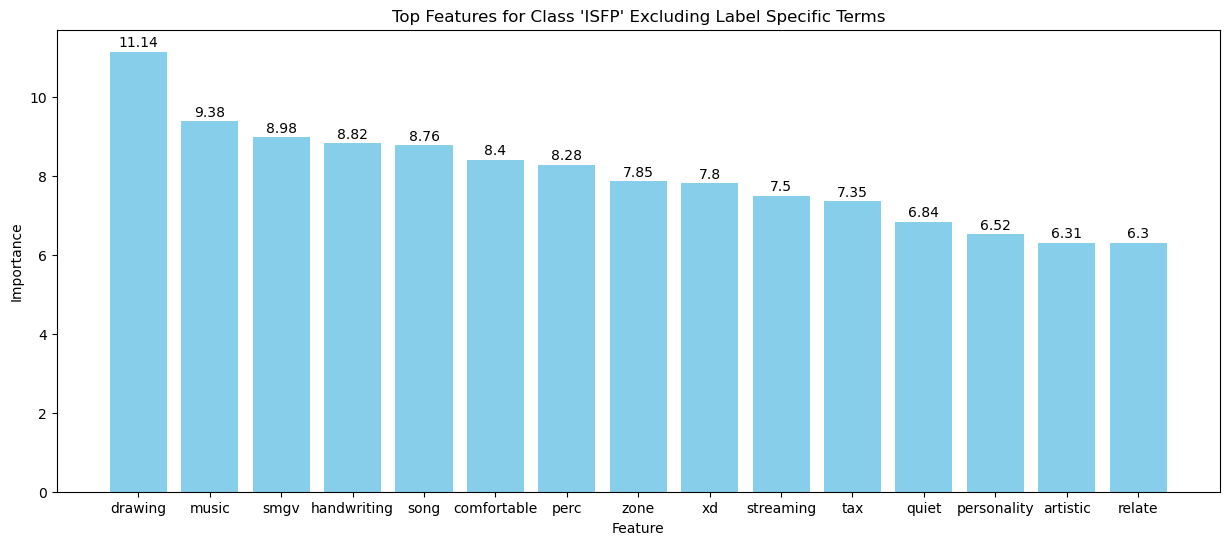

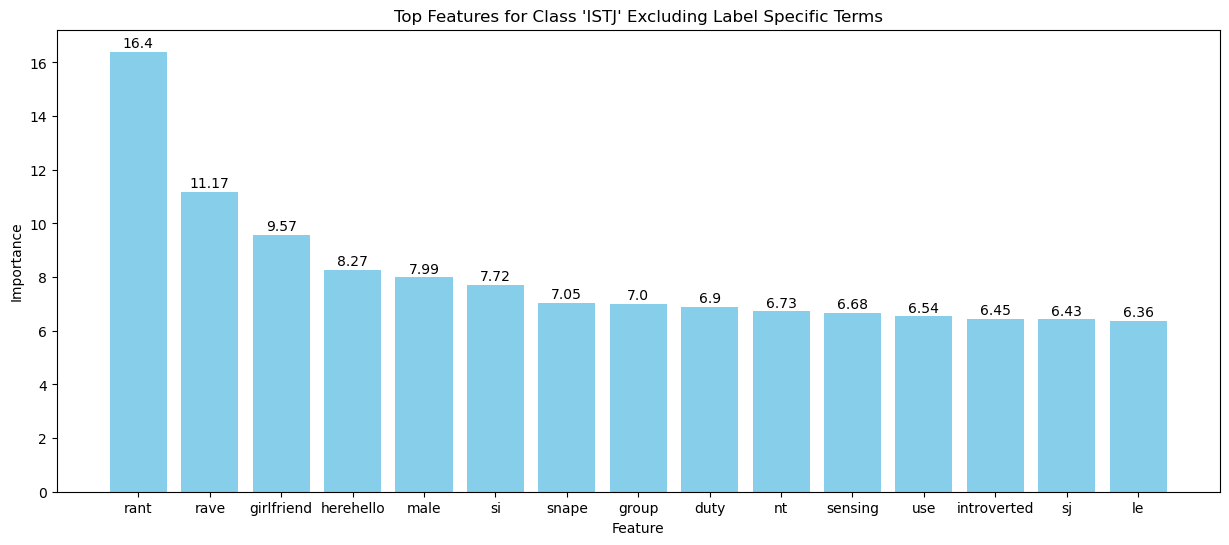

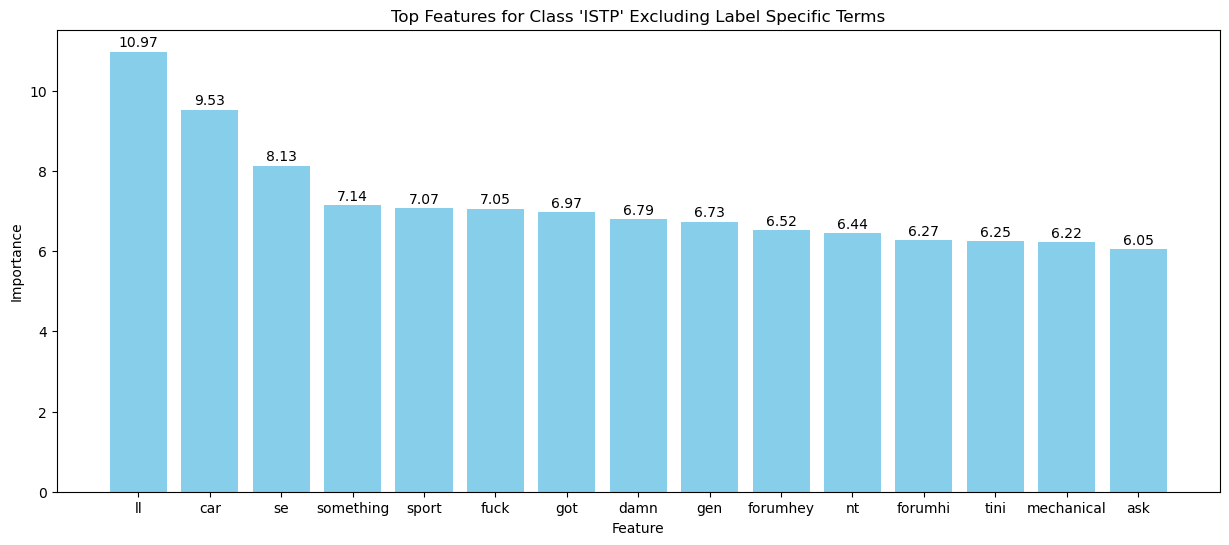

In [32]:
# Get feature names and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_

for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Exclude label-specific features
    filtered_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices
                         if class_name.lower() not in feature_names[i].lower()]

    # Select the top 10 features
    top_features = filtered_features[:15]
    features, importances = zip(*top_features)

    # Plotting
    plt.figure(figsize=(15, 6))
    bars = plt.bar(features, importances, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f"Top Features for Class '{class_name}' Excluding Label Specific Terms")
    plt.show()

In [ ]:
## 4.4: 

In [34]:
# Assuming 'map_label' is defined to map class indices to label names
for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Extract all features for this class
    all_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices]

    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_features, columns=['Feature', 'Importance'])
    df.to_csv(f'../output/all_features_for_{class_name}.csv', index=False)

    print(f"All features for class {class_name} saved to '../output/all_features_for_{class_name}.csv'")

All features for class ENFJ saved to '../output/all_features_for_ENFJ.csv'
All features for class ENFP saved to '../output/all_features_for_ENFP.csv'
All features for class ENTJ saved to '../output/all_features_for_ENTJ.csv'
All features for class ENTP saved to '../output/all_features_for_ENTP.csv'
All features for class ESFJ saved to '../output/all_features_for_ESFJ.csv'
All features for class ESFP saved to '../output/all_features_for_ESFP.csv'
All features for class ESTJ saved to '../output/all_features_for_ESTJ.csv'
All features for class ESTP saved to '../output/all_features_for_ESTP.csv'
All features for class INFJ saved to '../output/all_features_for_INFJ.csv'
All features for class INFP saved to '../output/all_features_for_INFP.csv'
All features for class INTJ saved to '../output/all_features_for_INTJ.csv'
All features for class INTP saved to '../output/all_features_for_INTP.csv'
All features for class ISFJ saved to '../output/all_features_for_ISFJ.csv'
All features for class IS